In [20]:
# Cell 1: Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Libraries imported successfully!")
print(f"📦 Pandas version: {pd.__version__}")
print(f"📦 Plotly version: {plotly.__version__}")  # ← Changed from px.__version__

✅ Libraries imported successfully!
📦 Pandas version: 2.3.0
📦 Plotly version: 6.3.1


In [21]:
# Cell 2: Load CSV data
CSV_PATH = r"C:\Users\ertugrul\Downloads\Supabase Snippet Pedestrian Counts with Sensor Locations.csv"

# Read CSV
df = pd.read_csv(CSV_PATH)

print("=" * 70)
print("📊 DATASET OVERVIEW")
print("=" * 70)
print(f"Total rows: {len(df):,}")
print(f"Total columns: {len(df.columns)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Unique sensors: {df['location_id'].nunique()}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\n" + "=" * 70)
print("📋 COLUMN NAMES")
print("=" * 70)
print(df.columns.tolist())

print("\n" + "=" * 70)
print("🔍 FIRST 5 ROWS")
print("=" * 70)
print(df.head())

print("\n" + "=" * 70)
print("📈 DATA TYPES")
print("=" * 70)
print(df.dtypes)

print("\n" + "=" * 70)
print("📊 BASIC STATISTICS")
print("=" * 70)
print(df[['pedestrian_count', 'direction_1', 'direction_2', 'hour']].describe())

📊 DATASET OVERVIEW
Total rows: 94,970
Total columns: 20
Date range: 2025-10-28 to 2025-10-29
Unique sensors: 99
Memory usage: 69.20 MB

📋 COLUMN NAMES
['location_id', 'melbourne_time', 'sensing_date', 'hour', 'day_of_week', 'day_name', 'direction_1', 'direction_2', 'pedestrian_count', 'sensor_name', 'sensor_description', 'location_type', 'status', 'latitude', 'longitude', 'direction_1_name', 'direction_2_name', 'date', 'time_of_day', 'day_type']

🔍 FIRST 5 ROWS
   location_id       melbourne_time sensing_date  hour  day_of_week  \
0            1  2025-10-28 01:13:00   2025-10-28     1            2   
1            1  2025-10-28 01:20:00   2025-10-28     1            2   
2            1  2025-10-28 01:28:00   2025-10-28     1            2   
3            1  2025-10-28 01:29:00   2025-10-28     1            2   
4            1  2025-10-28 01:43:00   2025-10-28     1            2   

    day_name  direction_1  direction_2  pedestrian_count sensor_name  \
0  Tuesday              1          

In [22]:
# Cell 3: Clean and prepare data

# Convert melbourne_time to datetime if it's not already
df['melbourne_time'] = pd.to_datetime(df['melbourne_time'])
df['date'] = pd.to_datetime(df['date'])

# Ensure numeric columns
df['pedestrian_count'] = pd.to_numeric(df['pedestrian_count'], errors='coerce')
df['hour'] = pd.to_numeric(df['hour'], errors='coerce')
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')

# Remove any rows with null pedestrian counts
df = df.dropna(subset=['pedestrian_count'])

# Create additional time features
df['hour_label'] = df['hour'].apply(lambda x: f"{int(x):02d}:00")
df['is_peak_hour'] = df['hour'].isin([8, 9, 12, 13, 17, 18])
df['is_business_hours'] = df['hour'].between(9, 17)

print("✅ Data cleaning complete!")
print(f"Rows after cleaning: {len(df):,}")
print(f"Missing values:\n{df.isnull().sum()[df.isnull().sum() > 0]}")

✅ Data cleaning complete!
Rows after cleaning: 94,970
Missing values:
Series([], dtype: int64)


In [23]:
# Cell 4: Summary by day and hour

print("=" * 70)
print("📅 DAILY SUMMARY")
print("=" * 70)

daily_summary = df.groupby('date').agg({
    'pedestrian_count': ['sum', 'mean', 'max'],
    'location_id': 'nunique',
    'melbourne_time': 'count'
}).round(2)

daily_summary.columns = ['Total Pedestrians', 'Avg Count', 'Peak Count', 'Active Sensors', 'Records']
print(daily_summary)

print("\n" + "=" * 70)
print("🕐 HOURLY AVERAGE (ALL DAYS)")
print("=" * 70)

hourly_avg = df.groupby('hour')['pedestrian_count'].agg(['mean', 'max', 'count']).round(2)
hourly_avg.columns = ['Avg Pedestrians', 'Peak Count', 'Records']
hourly_avg.index.name = 'Hour'
print(hourly_avg)

print("\n" + "=" * 70)
print("🏆 TOP 10 BUSIEST SENSORS")
print("=" * 70)

top_sensors = df.groupby(['location_id', 'sensor_name']).agg({
    'pedestrian_count': ['sum', 'mean', 'max'],
    'melbourne_time': 'count'
}).round(2)

top_sensors.columns = ['Total', 'Avg', 'Peak', 'Records']
top_sensors = top_sensors.sort_values('Total', ascending=False).head(10)
print(top_sensors)

📅 DAILY SUMMARY
            Total Pedestrians  Avg Count  Peak Count  Active Sensors  Records
date                                                                         
2025-10-28             426880      13.77         315              99    30991
2025-10-29             930864      14.55         466              99    63979

🕐 HOURLY AVERAGE (ALL DAYS)
      Avg Pedestrians  Peak Count  Records
Hour                                      
0                3.07          34     1431
1                2.46          15     1214
2                2.01          13      901
3                1.96          21      674
4                1.81          14      804
5                2.37          39     1633
6                4.63          77     3430
7                8.52         134     4318
8               16.63         374     4780
9               13.23         239     4819
10              11.98         206     4763
11              14.01         201     4849
12              21.77         272     496

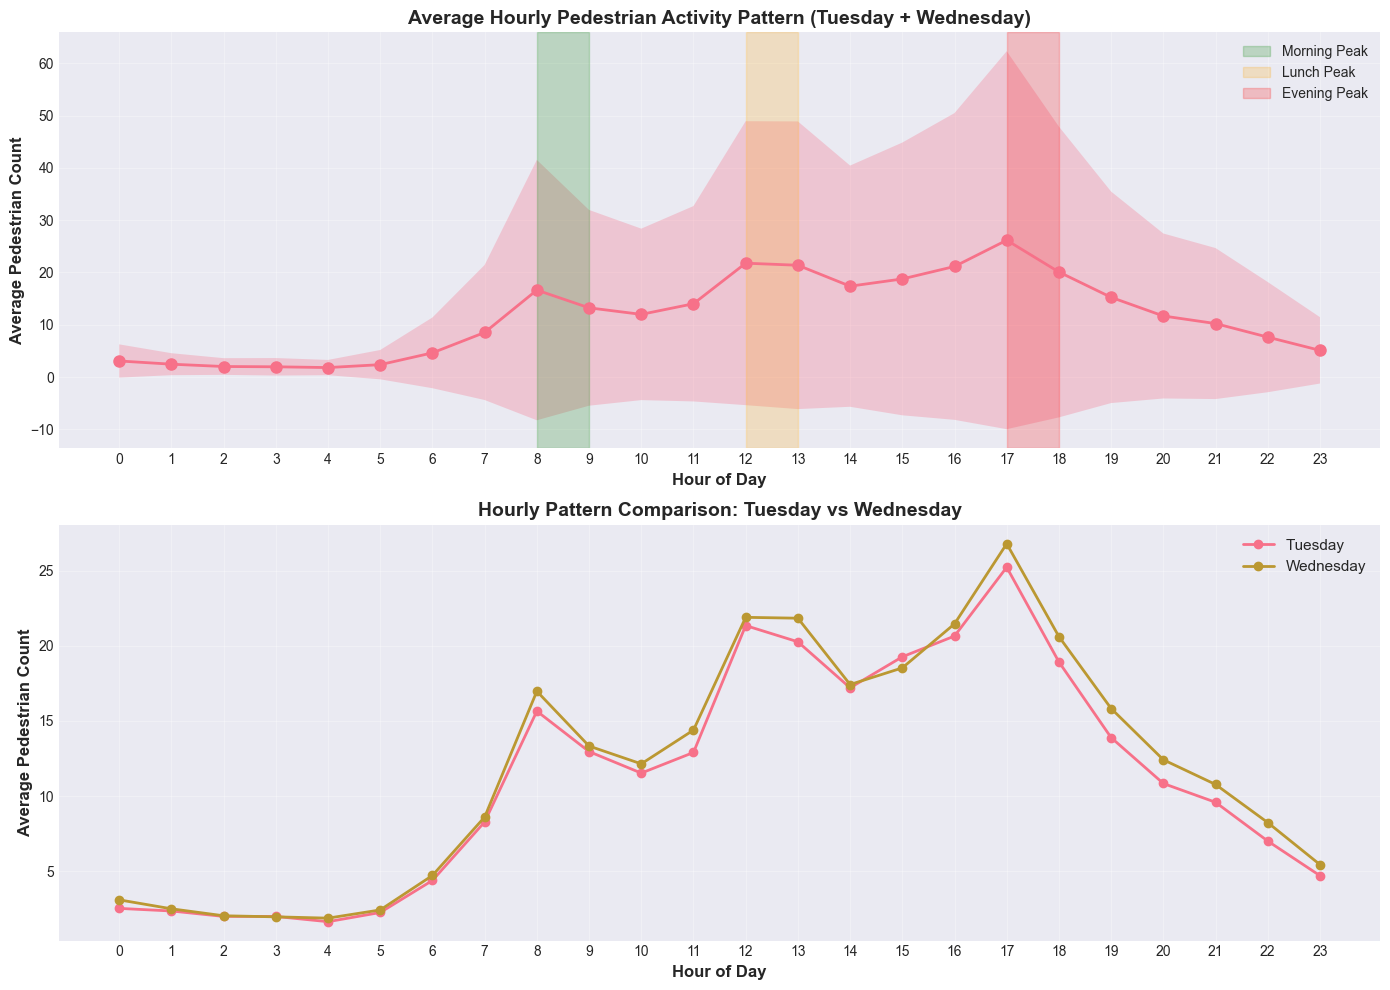

✅ Hourly pattern chart saved as 'hourly_pattern_analysis.png'


In [24]:
# Cell 5: Hourly activity pattern

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Average pedestrian count by hour (both days combined)
hourly_data = df.groupby('hour')['pedestrian_count'].agg(['mean', 'std']).reset_index()

axes[0].plot(hourly_data['hour'], hourly_data['mean'], marker='o', linewidth=2, markersize=8)
axes[0].fill_between(hourly_data['hour'], 
                      hourly_data['mean'] - hourly_data['std'], 
                      hourly_data['mean'] + hourly_data['std'], 
                      alpha=0.3)
axes[0].set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Average Pedestrian Count', fontsize=12, fontweight='bold')
axes[0].set_title('Average Hourly Pedestrian Activity Pattern (Tuesday + Wednesday)', 
                  fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(range(0, 24))
axes[0].axvspan(8, 9, alpha=0.2, color='green', label='Morning Peak')
axes[0].axvspan(12, 13, alpha=0.2, color='orange', label='Lunch Peak')
axes[0].axvspan(17, 18, alpha=0.2, color='red', label='Evening Peak')
axes[0].legend()

# Plot 2: Compare Tuesday vs Wednesday
hourly_by_day = df.groupby(['day_name', 'hour'])['pedestrian_count'].mean().reset_index()

for day in hourly_by_day['day_name'].unique():
    day_data = hourly_by_day[hourly_by_day['day_name'] == day]
    axes[1].plot(day_data['hour'], day_data['pedestrian_count'], 
                 marker='o', label=day, linewidth=2, markersize=6)

axes[1].set_xlabel('Hour of Day', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Average Pedestrian Count', fontsize=12, fontweight='bold')
axes[1].set_title('Hourly Pattern Comparison: Tuesday vs Wednesday', 
                  fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(range(0, 24))
axes[1].legend(fontsize=11)

plt.tight_layout()
plt.savefig('hourly_pattern_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Hourly pattern chart saved as 'hourly_pattern_analysis.png'")

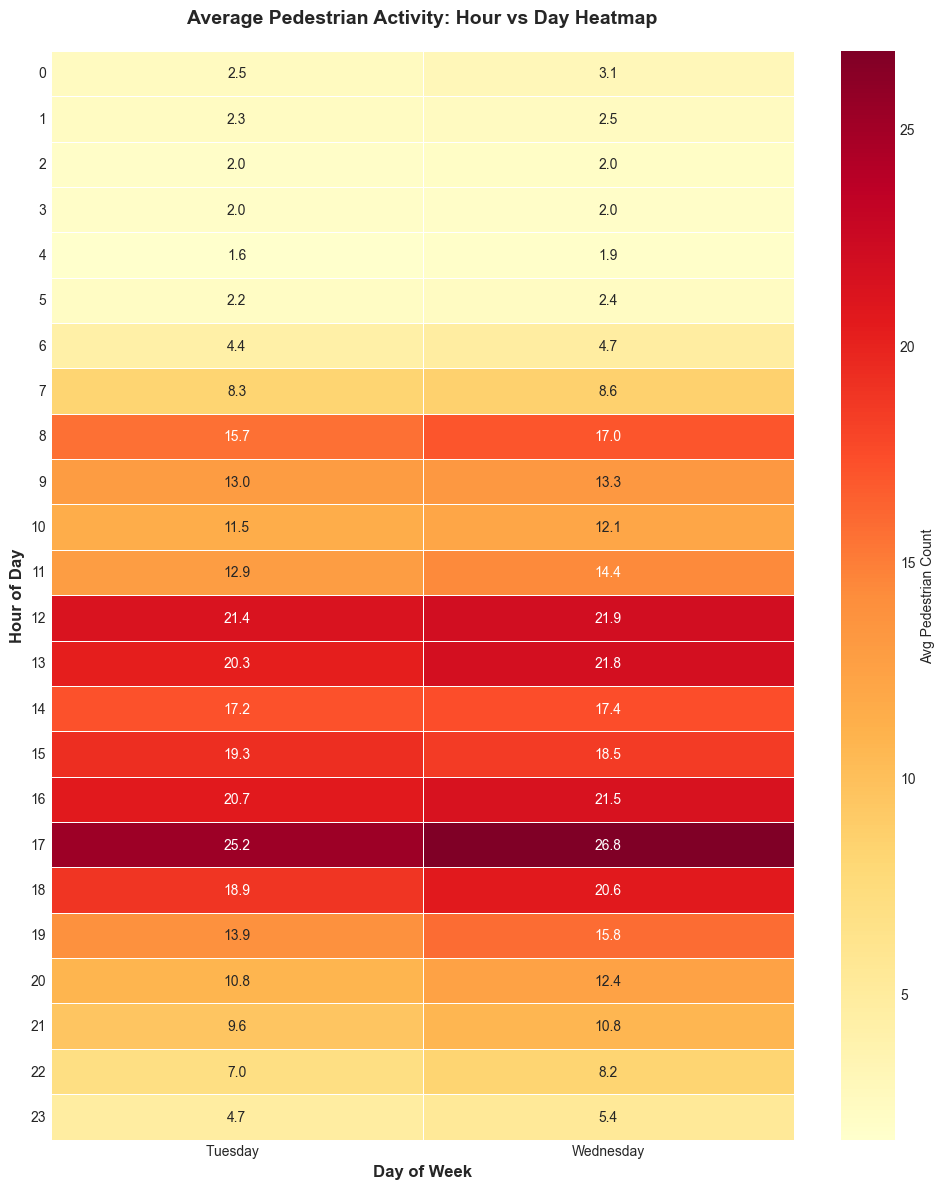

✅ Heatmap saved as 'heatmap_hour_vs_day.png'


In [25]:
# Cell 6: Heatmap showing activity by hour and day

# Create pivot table for heatmap
heatmap_data = df.pivot_table(
    values='pedestrian_count',
    index='hour',
    columns='day_name',
    aggfunc='mean'
)

plt.figure(figsize=(10, 12))
sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Avg Pedestrian Count'}, linewidths=0.5)
plt.title('Average Pedestrian Activity: Hour vs Day Heatmap', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Day of Week', fontsize=12, fontweight='bold')
plt.ylabel('Hour of Day', fontsize=12, fontweight='bold')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('heatmap_hour_vs_day.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Heatmap saved as 'heatmap_hour_vs_day.png'")

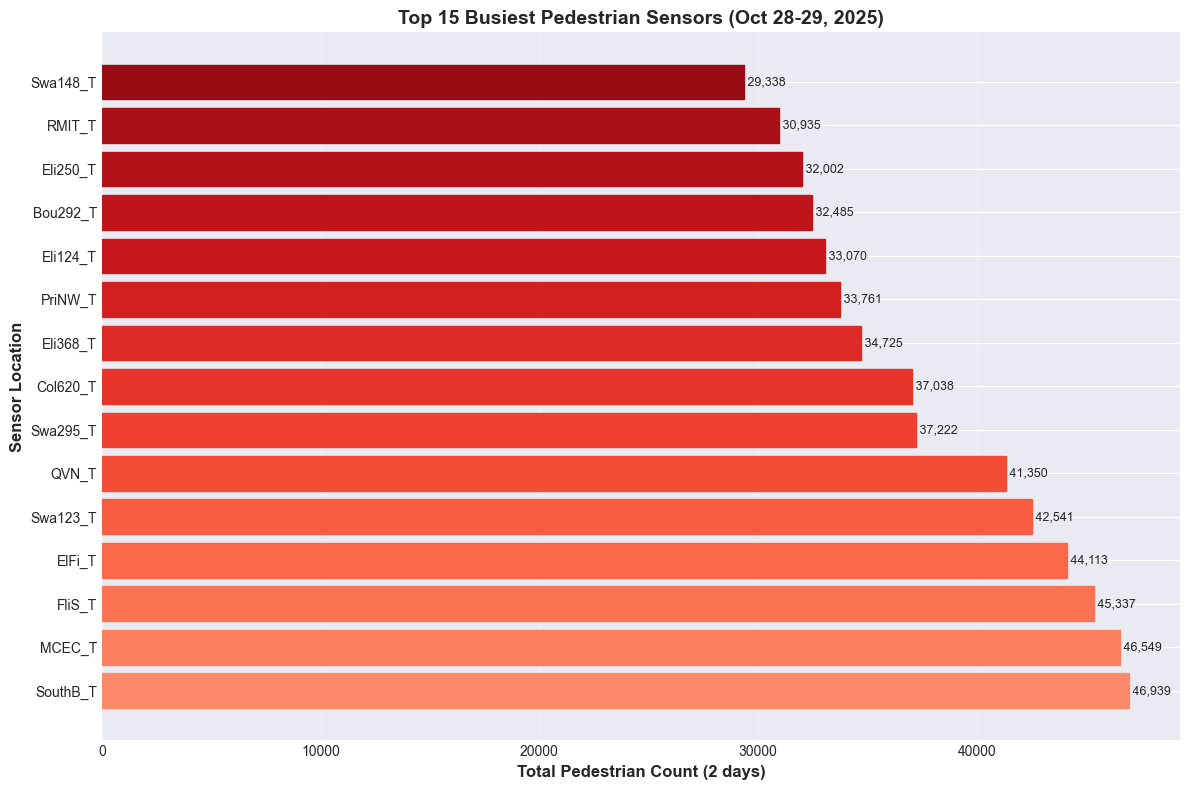

✅ Top sensors chart saved as 'top15_busiest_sensors.png'


In [26]:
# Cell 7: Top 15 busiest sensors

top15_sensors = df.groupby(['location_id', 'sensor_name']).agg({
    'pedestrian_count': 'sum'
}).reset_index().sort_values('pedestrian_count', ascending=False).head(15)

plt.figure(figsize=(12, 8))
bars = plt.barh(range(len(top15_sensors)), top15_sensors['pedestrian_count'])

# Color code by activity level
colors = plt.cm.Reds(np.linspace(0.4, 0.9, len(top15_sensors)))
for bar, color in zip(bars, colors):
    bar.set_color(color)

plt.yticks(range(len(top15_sensors)), top15_sensors['sensor_name'])
plt.xlabel('Total Pedestrian Count (2 days)', fontsize=12, fontweight='bold')
plt.ylabel('Sensor Location', fontsize=12, fontweight='bold')
plt.title('Top 15 Busiest Pedestrian Sensors (Oct 28-29, 2025)', 
          fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, (idx, row) in enumerate(top15_sensors.iterrows()):
    plt.text(row['pedestrian_count'], i, f" {int(row['pedestrian_count']):,}", 
             va='center', fontsize=9)

plt.tight_layout()
plt.savefig('top15_busiest_sensors.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Top sensors chart saved as 'top15_busiest_sensors.png'")

In [27]:
# Cell 8: Interactive map with Mapbox

# Aggregate sensor data for mapping
sensor_summary = df.groupby(['location_id', 'sensor_name', 'latitude', 'longitude']).agg({
    'pedestrian_count': ['sum', 'mean', 'max'],
    'melbourne_time': 'count'
}).reset_index()

sensor_summary.columns = ['location_id', 'sensor_name', 'latitude', 'longitude', 
                          'total_count', 'avg_count', 'peak_count', 'records']

# Remove sensors without coordinates
sensor_summary = sensor_summary.dropna(subset=['latitude', 'longitude'])

# Create hover text
sensor_summary['hover_text'] = sensor_summary.apply(
    lambda row: f"<b>{row['sensor_name']}</b><br>" +
                f"Total: {int(row['total_count']):,}<br>" +
                f"Avg: {row['avg_count']:.1f}<br>" +
                f"Peak: {int(row['peak_count']):,}<br>" +
                f"Records: {int(row['records']):,}",
    axis=1
)

# Create Mapbox scatter plot
fig = px.scatter_mapbox(
    sensor_summary,
    lat='latitude',
    lon='longitude',
    size='total_count',
    color='avg_count',
    hover_name='sensor_name',
    hover_data={
        'total_count': ':,',
        'avg_count': ':.1f',
        'peak_count': ':,',
        'latitude': False,
        'longitude': False
    },
    color_continuous_scale='YlOrRd',
    size_max=10,
    zoom=12,
    height=700,
    title='Melbourne Pedestrian Activity Map (Oct 28-29, 2025)'
)

fig.update_layout(
    
    mapbox_style="dark",
     mapbox_accesstoken="pk.eyJ1IjoiZXJ0dWdydWxha2RlbWlyIiwiYSI6ImNtZ3o0NXVsOTAyOXk3cHM4ZHJ0MmU1enMifQ.vj7BMAX9VFQbNGaqt9ixdQ",
    font=dict(size=12),
    title_font_size=16
)

fig.show()

# Save as HTML
fig.write_html('pedestrian_activity_map.html')
print("✅ Interactive map saved as 'pedestrian_activity_map.html'")
print("📍 Open the HTML file in your browser to interact with the map")

✅ Interactive map saved as 'pedestrian_activity_map.html'
📍 Open the HTML file in your browser to interact with the map


🔥 PEAK HOURS ANALYSIS

📊 Morning Rush (8 AM)
   Total records: 4,780
   Total pedestrians: 79,471
   Average per sensor: 16.63
   Peak sensor count: 374
   Top 3 locations:
      • MCEC_T: 209.5 avg
      • ElFi_T: 172.9 avg
      • PriNW_T: 99.7 avg

📊 Lunch Peak (12 PM)
   Total records: 4,967
   Total pedestrians: 108,126
   Average per sensor: 21.77
   Peak sensor count: 272
   Top 3 locations:
      • Eli124_T: 194.1 avg
      • MCEC_T: 187.9 avg
      • ElFi_T: 183.1 avg

📊 Evening Rush (5 PM)
   Total records: 6,121
   Total pedestrians: 160,132
   Average per sensor: 26.16
   Peak sensor count: 466
   Top 3 locations:
      • MCEC_T: 290.1 avg
      • ElFi_T: 284.0 avg
      • PriNW_T: 203.7 avg


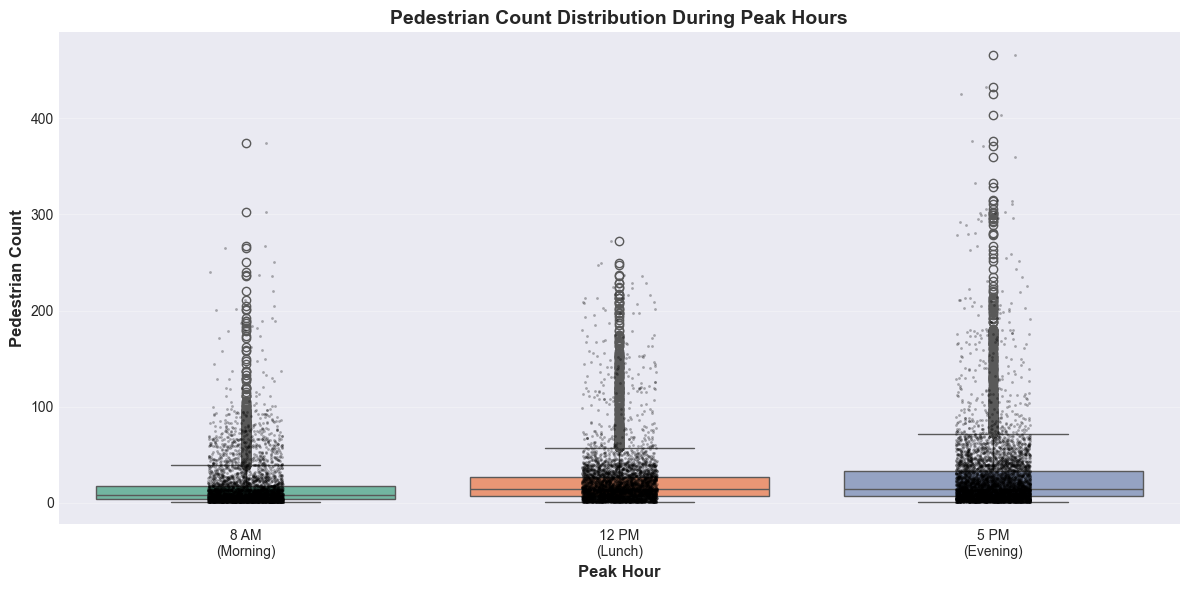


✅ Peak hours analysis chart saved as 'peak_hours_comparison.png'


In [28]:
# Cell 9: Peak hours detailed analysis

print("=" * 70)
print("🔥 PEAK HOURS ANALYSIS")
print("=" * 70)

peak_hours = [8, 12, 17]
peak_names = ['Morning Rush (8 AM)', 'Lunch Peak (12 PM)', 'Evening Rush (5 PM)']

for hour, name in zip(peak_hours, peak_names):
    hour_data = df[df['hour'] == hour]
    
    print(f"\n📊 {name}")
    print(f"   Total records: {len(hour_data):,}")
    print(f"   Total pedestrians: {hour_data['pedestrian_count'].sum():,}")
    print(f"   Average per sensor: {hour_data['pedestrian_count'].mean():.2f}")
    print(f"   Peak sensor count: {hour_data['pedestrian_count'].max()}")
    
    # Top 3 busiest locations during this hour
    top3 = hour_data.groupby('sensor_name')['pedestrian_count'].mean().sort_values(ascending=False).head(3)
    print(f"   Top 3 locations:")
    for loc, count in top3.items():
        print(f"      • {loc}: {count:.1f} avg")

# Visualize peak hours comparison
peak_data = df[df['hour'].isin(peak_hours)].copy()
peak_data['hour_label'] = peak_data['hour'].map({8: '8 AM\n(Morning)', 
                                                   12: '12 PM\n(Lunch)', 
                                                   17: '5 PM\n(Evening)'})

plt.figure(figsize=(12, 6))
sns.boxplot(data=peak_data, x='hour_label', y='pedestrian_count', palette='Set2')
sns.stripplot(data=peak_data, x='hour_label', y='pedestrian_count', 
              color='black', alpha=0.3, size=2)

plt.title('Pedestrian Count Distribution During Peak Hours', 
          fontsize=14, fontweight='bold')
plt.xlabel('Peak Hour', fontsize=12, fontweight='bold')
plt.ylabel('Pedestrian Count', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('peak_hours_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Peak hours analysis chart saved as 'peak_hours_comparison.png'")

🌅 TIME OF DAY SUMMARY
              Total    Avg  Peak  Sensors  Records
time_of_day                                       
Morning      320908  11.90   374       99    26959
Afternoon    658534  21.30   466       99    30917
Evening      362457  11.91   323       99    30437
Night         15845   2.38    39       96     6657


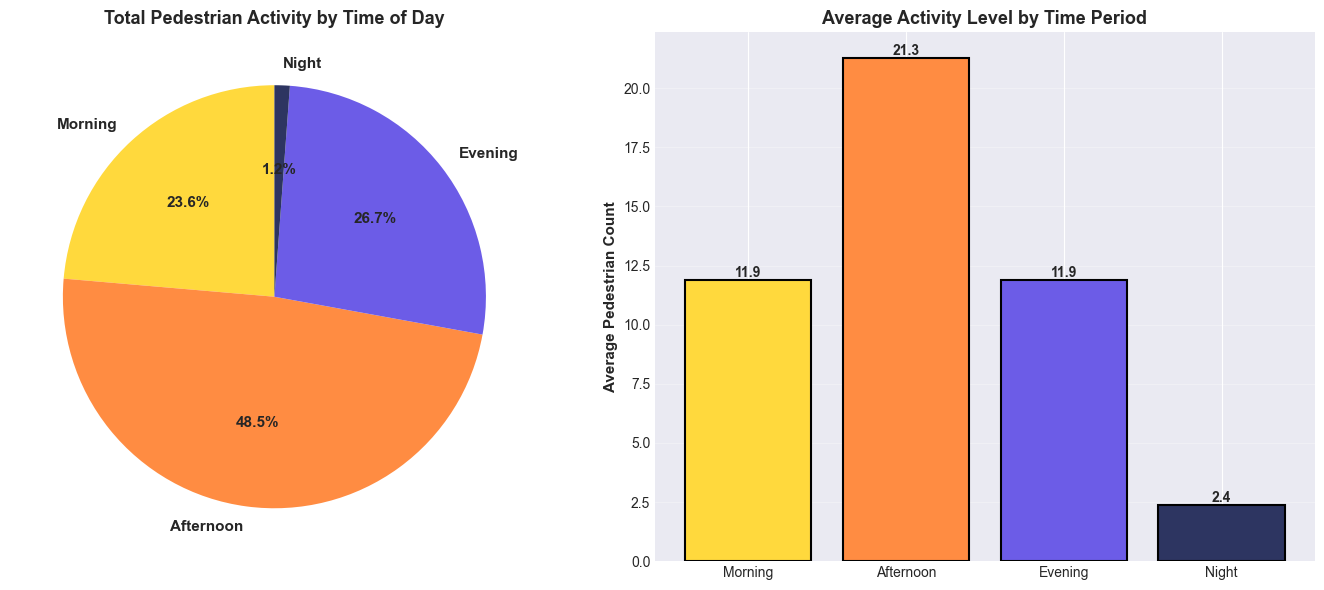


✅ Time of day analysis saved as 'time_of_day_analysis.png'


In [29]:
# Cell 10: Time of day patterns

time_of_day_summary = df.groupby('time_of_day').agg({
    'pedestrian_count': ['sum', 'mean', 'max'],
    'location_id': 'nunique',
    'melbourne_time': 'count'
}).round(2)

time_of_day_summary.columns = ['Total', 'Avg', 'Peak', 'Sensors', 'Records']

# Order by time of day
time_order = ['Morning', 'Afternoon', 'Evening', 'Night']
time_of_day_summary = time_of_day_summary.reindex(time_order)

print("=" * 70)
print("🌅 TIME OF DAY SUMMARY")
print("=" * 70)
print(time_of_day_summary)

# Pie chart
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Pie chart 1: Total pedestrians by time of day
time_totals = df.groupby('time_of_day')['pedestrian_count'].sum()
time_totals = time_totals.reindex(time_order)

colors = ['#FFD93D', '#FF8C42', '#6C5CE7', '#2D3561']
ax1.pie(time_totals, labels=time_order, autopct='%1.1f%%', colors=colors,
        startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
ax1.set_title('Total Pedestrian Activity by Time of Day', 
              fontsize=13, fontweight='bold')

# Bar chart 2: Average by time of day
time_avg = df.groupby('time_of_day')['pedestrian_count'].mean().reindex(time_order)
bars = ax2.bar(time_order, time_avg, color=colors, edgecolor='black', linewidth=1.5)
ax2.set_ylabel('Average Pedestrian Count', fontsize=11, fontweight='bold')
ax2.set_title('Average Activity Level by Time Period', 
              fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('time_of_day_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Time of day analysis saved as 'time_of_day_analysis.png'")

In [30]:
# Cell 11: Key insights and statistics

print("=" * 70)
print("🎯 KEY INSIGHTS & FINDINGS")
print("=" * 70)

# 1. Peak hour identification
peak_hour = df.groupby('hour')['pedestrian_count'].mean().idxmax()
peak_hour_avg = df.groupby('hour')['pedestrian_count'].mean().max()

print(f"\n📊 PEAK ACTIVITY")
print(f"   • Peak hour: {int(peak_hour)}:00 ({peak_hour_avg:.1f} avg pedestrians)")

# 2. Busiest sensor
busiest_sensor = df.groupby('sensor_name')['pedestrian_count'].sum().idxmax()
busiest_count = df.groupby('sensor_name')['pedestrian_count'].sum().max()

print(f"\n🏆 BUSIEST LOCATION")
print(f"   • {busiest_sensor}")
print(f"   • Total: {busiest_count:,} pedestrians")

# 3. Day comparison
day_comparison = df.groupby('day_name')['pedestrian_count'].agg(['sum', 'mean'])
print(f"\n📅 DAY COMPARISON")
for day in day_comparison.index:
    print(f"   • {day}: {int(day_comparison.loc[day, 'sum']):,} total, " +
          f"{day_comparison.loc[day, 'mean']:.1f} average")

# 4. Business hours vs non-business
business_hours_pct = (df[df['is_business_hours']]['pedestrian_count'].sum() / 
                      df['pedestrian_count'].sum() * 100)
print(f"\n⏰ BUSINESS HOURS (9 AM - 5 PM)")
print(f"   • {business_hours_pct:.1f}% of total activity occurs during business hours")

# 5. Data quality
print(f"\n✅ DATA QUALITY")
print(f"   • Total records: {len(df):,}")
print(f"   • Unique sensors: {df['location_id'].nunique()}")
print(f"   • Date range: {df['date'].min()} to {df['date'].max()}")
print(f"   • Hours covered: {df['hour'].nunique()} out of 24")
print(f"   • Missing coordinates: {df['latitude'].isna().sum()}")

print("\n" + "=" * 70)
print("✅ ANALYSIS COMPLETE!")
print("=" * 70)

🎯 KEY INSIGHTS & FINDINGS

📊 PEAK ACTIVITY
   • Peak hour: 17:00 (26.2 avg pedestrians)

🏆 BUSIEST LOCATION
   • SouthB_T
   • Total: 46,939 pedestrians

📅 DAY COMPARISON
   • Tuesday  : 426,880 total, 13.8 average
   • Wednesday: 930,864 total, 14.5 average

⏰ BUSINESS HOURS (9 AM - 5 PM)
   • 62.4% of total activity occurs during business hours

✅ DATA QUALITY
   • Total records: 94,970
   • Unique sensors: 99
   • Date range: 2025-10-28 00:00:00 to 2025-10-29 00:00:00
   • Hours covered: 24 out of 24
   • Missing coordinates: 0

✅ ANALYSIS COMPLETE!


In [31]:
# Cell 12: Animated hourly activity map (optional)
import plotly.express as px

# Aggregate by hour for animation
hourly_map_data = df.groupby(['hour', 'location_id', 'sensor_name', 'latitude', 'longitude']).agg({
    'pedestrian_count': 'mean'
}).reset_index()

# Remove sensors without coordinates
hourly_map_data = hourly_map_data.dropna(subset=['latitude', 'longitude'])

# Create animated map
fig = px.scatter_mapbox(
    hourly_map_data,
    lat='latitude',
    lon='longitude',
    size='pedestrian_count',
    color='pedestrian_count',
    hover_name='sensor_name',
    animation_frame='hour',
    color_continuous_scale='YlOrRd',
    size_max=30,
    zoom=12,
    height=700,
    title='Melbourne Pedestrian Activity - Hourly Animation'
)

fig.update_layout(
    mapbox_style="dark",
    mapbox_accesstoken="pk.eyJ1IjoiZXJ0dWdydWxha2RlbWlyIiwiYSI6ImNtZ3o0NXVsOTAyOXk3cHM4ZHJ0MmU1enMifQ.vj7BMAX9VFQbNGaqt9ixdQ"
)

fig.show()
fig.write_html('pedestrian_activity_animated.html')
print("✅ Animated map saved as 'pedestrian_activity_animated.html'")

✅ Animated map saved as 'pedestrian_activity_animated.html'
